In [5]:
from importlib import reload
import gnn_tracking_hpo
reload(gnn_tracking_hpo)

from gnn_tracking_hpo.util.paths import add_scripts_path
from gnn_tracking.graph_construction.graph_builder import load_graphs
from torch_geometric.loader import DataLoader
import torch
from tqdm import tqdm
import numpy as np
from gnn_tracking.postprocessing.clusterscanner import sort_according_to_mask
from gnn_tracking.metrics.cluster_metrics import tracking_metrics
from gnn_tracking.postprocessing.dbscanscanner import dbscan
import multiprocessing
from functools import partial

add_scripts_path()

In [2]:
from tune_fixed_ec import PretrainedECTrainable

In [3]:
trainable = PretrainedECTrainable.reinstate("fixed-ec-51f87ec0", "af5b5461", epoch=-1, n_graphs=0)

[11:13:00 gnnt_hpo] DEBUG: Loading config from /home/kl5675/ray_results/fixed-ec-51f87ec0/PretrainedECTrainable_af5b5461_4_attr_pt_thld=0.6079,batch_size=5,ec_epoch=32,ec_hash=51f87ec0,ec_project=ec,ec_pt_thld=0.0000,gnn_2023-02-01_10-37-15/params.json
[11:13:00 gnnt_hpo] INFO: Initializing pre-trained EC
[11:13:06 gnnt_hpo] DEBUG: Loading config from /home/kl5675/ray_results/ec/ECTrainable_51f87ec0_1_batch_size=5,ec_pt_thld=0.7711,focal_alpha=0.3824,focal_gamma=2.5581,gnn_tracking_experiments_hash=f2480a9a_2023-01-30_23-14-13/params.json
[11:13:06 gnnt_hpo] INFO: I'm running on a node with job ID=45944642
[11:13:06 gnnt_hpo] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[11:13:06 gnnt_hpo] INFO: The ID of my dispatcher is 0
[11:13:06 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[11:13:06 gnnt_hpo] DEBUG: Got config
┌──────────────────────────────────────┬───────────────────────

In [6]:
graphs = load_graphs("/scratch/gpfs/kl5675/data/gnn_tracking/graphs/training_part09", stop=100, n_processes=6)

[11:13:25] INFO: Loading 100 graphs (out of 3200 available).
[11:13:25] DEBUG: First graph is data29004_s0.pt, last graph is data29032_s11.pt


In [50]:
loader = DataLoader(graphs, num_workers=6)

In [51]:
trainer = trainable.trainer
trainer.model.eval()

cluster_input = []
with torch.no_grad():
    for idx, data in tqdm(enumerate(loader), total=len(graphs)):
        model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        mo = model_output
        cluster_input.append(
            dict(
                x=mo["x"].cpu().numpy(),
                truth=mo["particle_id"].cpu().numpy(),
                pts=mo["pt"].cpu().numpy(),
                reconstructable=mo["reconstructable"].cpu().numpy(),
                sector=mo["sector"].cpu().numpy(),
                node_mask=mo["ec_hit_mask"].cpu().numpy(),
            )
        )
        # if idx == stop:
        #     break

100%|███████████████████████████████████████████████████████████████████| 500/500 [05:52<00:00,  1.42it/s]


In [52]:
eps = np.linspace(0.5, 1.1, 100)

In [53]:
def _pad_output_with_noise(labels: np.ndarray, length: int) -> np.ndarray:
    """Pad clustering output to length with noise labels."""
    return np.concatenate([labels, np.full(length - len(labels), -1)])

In [54]:


def worker(inpt, e):
    results = {}
    for sector in np.unique(inpt["sector"]):
        if sector < 0:
            continue
        # fixme: Return this to the original
        node_mask = inpt["node_mask"]

        def msort(key):
            return sort_according_to_mask([inpt[key]], [node_mask])[0]

        sector_mask = sector == msort("sector")
        sector_mask_for_mo = sector == inpt["sector"][inpt["node_mask"]]
        reconstructable = msort("reconstructable")[sector_mask]
        pts = msort("pts")[sector_mask]
        truth = msort("truth")[sector_mask]
        labels = _pad_output_with_noise(
            dbscan(inpt["x"][sector_mask_for_mo], eps=e, min_samples=1),
            len(reconstructable)
        )
        results[sector] = tracking_metrics(
            truth=truth,
            pts=pts,
            reconstructable=reconstructable,
            predicted=labels,
            pt_thlds=[0.9],
        )
    return results

def get():
    results = []
    with multiprocessing.Pool(6) as pool:
        for e in tqdm(eps):
            _results = pool.map(partial(worker, e=e), cluster_input)
            results.append(_results)
    # worker(cluster_input[0], 0.5)
    return results

In [55]:
dms = get()

100%|███████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.26s/it]


In [94]:
def retrieve(results, key="double_majority", sector=None):
    # list of values for every epsilon
    value_lstlst = []
    for epsresults in results:
        epsresults_flat = []
        for inptresults in epsresults:
            if sector is None:
                for metrics in inptresults.values():
                    epsresults_flat.append(metrics[0.9][key])
            else:
                if not sector in inptresults:
                    continue
                epsresults_flat.append(inptresults[sector][0.9][key])
        value_lstlst.append(epsresults_flat)
    means = [np.mean(lst) for lst in value_lstlst]
    stds = [np.std(lst) / np.sqrt(len(lst)) for lst in value_lstlst]
    # print(np.std(value_lstlst[0]), np.sqrt(len(value_lstlst[0])))
    return np.array(means), np.array(stds)

In [95]:
import matplotlib.pyplot as plt

In [96]:
def plot_error_band(ax, xs, ys, eys, color):
    ax.fill_between(xs, ys-eys, ys+eys, color=color, alpha=0.2)
    ax.plot(xs, ys, c=color)

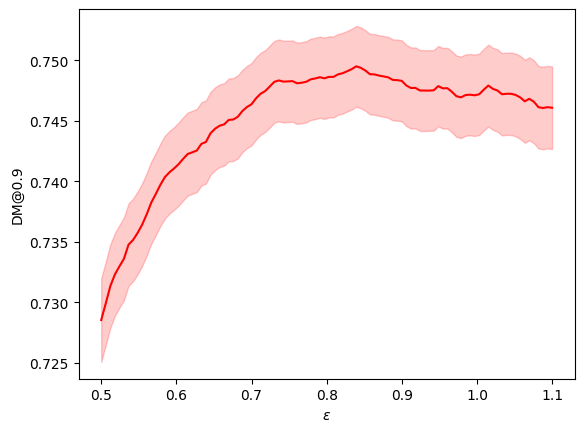

In [97]:
fig, ax = plt.subplots()
ax.set_ylabel("DM@0.9")
ax.set_xlabel(r"$\epsilon$")
plot_error_band(ax, eps, *retrieve(dms), "r")
# plot_error_band(ax, eps, *retrieve(dms, "perfect"), "k")

In [98]:
def get_best_for_sector(results, eps, sector: int):
    vals, errs = retrieve(results, sector=sector)
    idx = np.argmax(vals)
    eps_err_up = np.max(eps[vals > vals[idx] - errs[idx]]) - eps[idx]
    eps_err_down = eps[idx] - np.min(eps[vals > vals[idx] - errs[idx]])
    return eps[idx], vals[idx], errs[idx], eps_err_down, eps_err_up

Text(0, 0.5, 'DM@0.9')

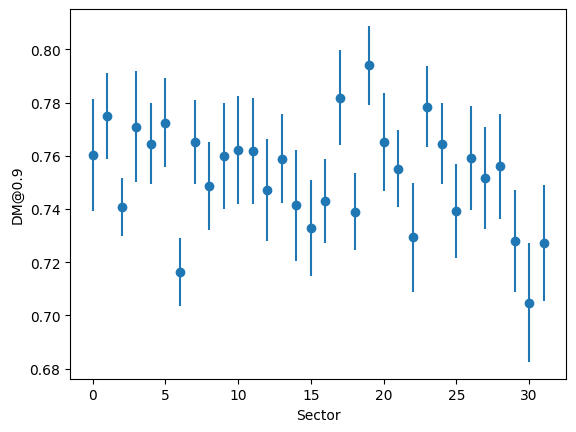

In [99]:
fig, ax = plt.subplots()
sectors = np.arange(0, 32)
sres = np.array([get_best_for_sector(dms, eps, s) for s in sectors])
ax.errorbar(sectors, sres[:, 1], yerr=sres[:, 2], ls="", marker="o")
ax.set_xlabel("Sector")
ax.set_ylabel("DM@0.9")

(array([2., 4., 7., 9., 8., 2.]),
 array([0.70479852, 0.71965758, 0.73451664, 0.7493757 , 0.76423475,
        0.77909381, 0.79395287]),
 <BarContainer object of 6 artists>)

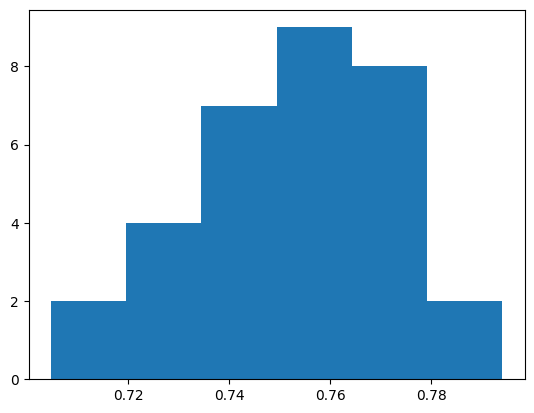

In [100]:
plt.hist(np.array([get_best_for_sector(dms, eps, s)[1] for s in sectors]), bins="auto")

Text(0.5, 1.0, "Errors: Min/max $\\epsilon$ for which DM doesn't change by more than 1$\\sigma$ from max")

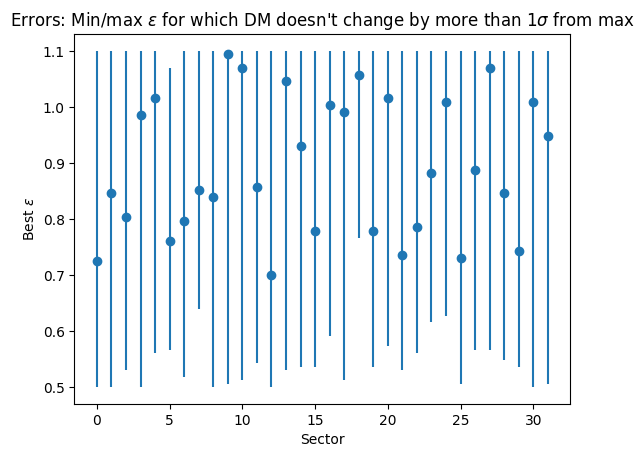

In [101]:
fig, ax = plt.subplots()
ax.errorbar(sectors, sres[:, 0], yerr=(sres[:, -2], sres[:, -1]), marker="o", ls="")
ax.set_xlabel("Sector")
ax.set_ylabel(r"Best $\epsilon$")
ax.set_title(r"Errors: Min/max $\epsilon$ for which DM doesn't change by more than 1$\sigma$ from max")